In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
##import lstm
import time
import warnings
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline 


In [2]:
#Display sample 

print('sample for Amazon:\n')
print(pd.read_csv('data/AMZN.csv').head())
print('\n')

print('sample for Walt Disney Company:\n')
print(pd.read_csv('data/DIS.csv').head())
print('\n')

print('sample for Microsoft Corporation:\n')
print(pd.read_csv('data/MSFT.csv').head())
print('\n')

print('sample for  S&P 500:\n')
print(pd.read_csv('data/SPY.csv').head())

sample for Amazon:

       Date     Open     High        Low    Close    Volume  Adj Close
0  1/3/2000  81.5000  89.5625  79.046799  89.3750  16117600    89.3750
1  1/4/2000  85.3750  91.5000  81.750000  81.9375  17487400    81.9375
2  1/5/2000  70.5000  75.1250  68.000000  69.7500  38457400    69.7500
3  1/6/2000  71.3125  72.6875  64.000000  65.5625  18752000    65.5625
4  1/7/2000  67.0000  70.5000  66.187500  69.5625  10505400    69.5625


sample for Walt Disney Company:

       Date       Open       High        Low      Close    Volume  Adj Close
0  1/3/2000  28.846153  29.524162  28.353058  29.462524   8404800  23.612387
1  1/4/2000  29.585798  31.434912  29.585798  31.188362  16056100  24.995544
2  1/5/2000  31.188362  32.667652  31.188362  32.482742  19829900  26.032913
3  1/6/2000  32.482742  32.667652  31.188362  31.188362   7905600  24.995544
4  1/7/2000  31.188362  31.681459  30.387081  30.695267   6775600  24.600359


sample for Microsoft Corporation:

       Date      Ope

In [3]:
"""Utility functions"""



def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        # TODO: Read and join data for each symbol
        df_temp = pd.read_csv(symbol_to_path(symbol),index_col = "Date",parse_dates = True,usecols = ['Date','Adj Close'],na_values = ['nan'])
        df_temp= df_temp.rename(columns = {'Adj Close':symbol})
        df = df.join(df_temp)
        
        if symbol == 'SPY':
            df=df.dropna(subset = ["SPY"])
    return df

    


def test_run():
    # Define a date range
    dates = pd.date_range('2000-01-01', '2017-07-28')

    # Choose stock symbols to read
    symbols = ['DIS','AMZN','MSFT','SPY']
    
    # Get stock data
    df = get_data(symbols, dates)
    print df.head()


if __name__ == "__main__":
    test_run()


                  DIS     AMZN       MSFT         SPY
2000-01-03  23.612387  89.3750  39.110466  104.855598
2000-01-04  24.995544  81.9375  37.789314  100.755112
2000-01-05  26.032913  69.7500  38.187756  100.935326
2000-01-06  24.995544  65.5625  36.908543   99.313148
2000-01-07  24.600359  69.5625  37.390865  105.080872


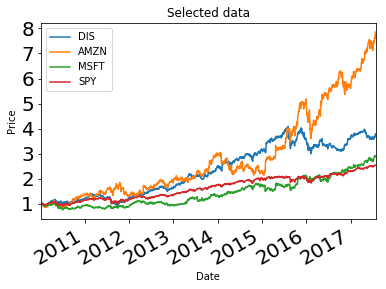

In [4]:
"""Slice,plot and normalize"""

def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=20)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    # TODO: Your code here
    sel = plot_data(df.loc[start_index:end_index,columns],title = 'Selected data')
    return sel

def normalized (df):
    """Normalize stock prizes using first dataframe row"""
    return df/df.iloc[0,:]


def test_run1():
    # Define a date range
    dates = pd.date_range('2010-01-03', '2017-07-28')

    # Choose stock symbols to read
    symbols = ['DIS','AMZN','MSFT','SPY']  # SPY will be added in get_data()
    
    # Get stock data
    df = get_data(symbols, dates)
    
    df = normalized(df)

    # Slice and plot
    plot_selected(df, ['DIS','AMZN','MSFT','SPY'], '2010-01-03', '2017-07-28')
   


if __name__ == "__main__":
    test_run1()



               DIS         AMZN         MSFT          SPY
count  4421.000000  4421.000000  4421.000000  4421.000000
mean     42.016462   190.310063    27.338878   121.304903
std      29.679853   228.561495    12.550046    45.723925
min      11.074709     5.970000    12.236407    57.161503
25%      21.503023    38.439999    19.353493    89.097977
50%      29.171387    79.190002    22.527864   105.394592
75%      53.108875   264.269989    29.354351   141.670441
max     118.245178  1052.800049    74.220001   247.429993


/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).mean()
/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).std()
/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


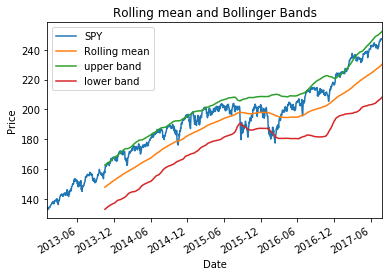

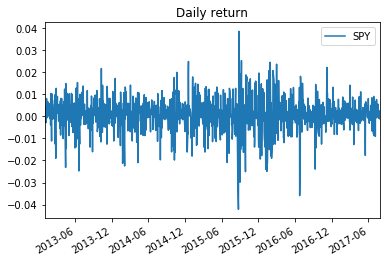

In [11]:
"""Statistical Analysis of Time Series"""

# Define a date range
dates = pd.date_range('2000-01-03', '2017-07-28')

# Choose stock symbols to read
symbols = ['DIS','AMZN','MSFT','SPY']  # SPY will be added in get_data()
    
 # Get stock data
df = get_data(symbols, dates)


print(df.describe())    

def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return pd.rolling_mean(values, window=window)


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return pd.rolling_std(values,window=window)


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    
    upper_band = rm + rstd * 2
    lower_band = rm - rstd *2
    return upper_band, lower_band

def daily_return(df):
    """compute the daily return"""
    dailyReturn = (df/df.shift(1)) - 1
    dailyReturn.ix[0,:] = 0
    return dailyReturn


def test_run2():
    # Read data
    dates = pd.date_range('2013-01-01', '2017-07-28')
    symbols = ['SPY']
    df = get_data(symbols, dates)
   
    # Compute Bollinger Bands
    # 1. Compute rolling mean
    rm_SPY = get_rolling_mean(df['SPY'], window=200)

    # 2. Compute rolling standard deviation
    rstd_SPY = get_rolling_std(df['SPY'], window=200)

    # 3. Compute upper and lower bands
    upper_band, lower_band = get_bollinger_bands(rm_SPY, rstd_SPY)
     #4. compute daily return
    daily = daily_return(df)
    
   
    # Plot raw SPY values, rolling mean and Bollinger Bands
    ax = df['SPY'].plot(title="Rolling mean and Bollinger Bands", label='SPY')
    rm_SPY.plot(label='Rolling mean', ax=ax)
    upper_band.plot(label='upper band', ax=ax)
    lower_band.plot(label='lower band', ax=ax)
    
    
    daily.plot(title='Daily return',label='daily return')
    
    

    # Add axis labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()


if __name__ == "__main__":
    test_run2()

    

In [12]:
"""Define functions to load the data normalize it, build the LSTM model(Deep Recurrent Neural network) and to predict"""

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
#warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(stock, seq_len, normalise_window):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    if normalise_window:
        result = normalise_windows(result)    

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model


def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs



> Loading data... 
> Data Loaded. Compiling...


/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
/home/foko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


('> Compilation Time : ', 0.013570785522460938)
Train on 3539 samples, validate on 394 samples
Epoch 1/500
3539/3539 [==============================] - 8s - loss: 0.0028 - val_loss: 3.7815e-04
Epoch 2/500
3539/3539 [==============================] - 9s - loss: 6.9891e-04 - val_loss: 2.9859e-04
Epoch 3/500
3539/3539 [==============================] - 13s - loss: 6.6681e-04 - val_loss: 4.4203e-04
Epoch 4/500
3539/3539 [==============================] - 8s - loss: 8.1206e-04 - val_loss: 2.9182e-04
Epoch 5/500
3539/3539 [==============================] - 7s - loss: 5.3390e-04 - val_loss: 3.1809e-04
Epoch 6/500
3539/3539 [==============================] - 6s - loss: 6.2754e-04 - val_loss: 4.4763e-04
Epoch 7/500
3539/3539 [==============================] - 6s - loss: 5.3708e-04 - val_loss: 2.2973e-04
Epoch 8/500
3539/3539 [==============================] - 6s - loss: 5.0102e-04 - val_loss: 2.1330e-04
Epoch 9/500
3539/3539 [==============================] - 6s - loss: 5.1544e-04 - val_loss: 3

3539/3539 [==============================] - 5s - loss: 2.2339e-04 - val_loss: 1.0203e-04
Epoch 80/500
3539/3539 [==============================] - 5s - loss: 2.0380e-04 - val_loss: 1.1195e-04
Epoch 81/500
3539/3539 [==============================] - 6s - loss: 2.3995e-04 - val_loss: 1.0749e-04
Epoch 82/500
3539/3539 [==============================] - 6s - loss: 2.0269e-04 - val_loss: 8.2515e-05
Epoch 83/500
3539/3539 [==============================] - 6s - loss: 2.4983e-04 - val_loss: 9.1588e-05
Epoch 84/500
3539/3539 [==============================] - 6s - loss: 2.1863e-04 - val_loss: 1.1184e-04
Epoch 85/500
3539/3539 [==============================] - 6s - loss: 2.3662e-04 - val_loss: 7.7939e-05
Epoch 86/500
3539/3539 [==============================] - 6s - loss: 2.0458e-04 - val_loss: 8.6930e-05
Epoch 87/500
3539/3539 [==============================] - 9s - loss: 2.5490e-04 - val_loss: 9.2111e-05
Epoch 88/500
3539/3539 [==============================] - 8s - loss: 2.0705e-04 - val_

3539/3539 [==============================] - 6s - loss: 2.2161e-04 - val_loss: 7.3457e-05
Epoch 159/500
3539/3539 [==============================] - 7s - loss: 1.8396e-04 - val_loss: 8.1862e-05
Epoch 160/500
3539/3539 [==============================] - 6s - loss: 2.1110e-04 - val_loss: 9.8235e-05
Epoch 161/500
3539/3539 [==============================] - 5s - loss: 1.9154e-04 - val_loss: 8.7431e-05
Epoch 162/500
3539/3539 [==============================] - 5s - loss: 2.0227e-04 - val_loss: 9.1217e-05
Epoch 163/500
3539/3539 [==============================] - 7s - loss: 1.9991e-04 - val_loss: 7.4980e-05
Epoch 164/500
3539/3539 [==============================] - 6s - loss: 1.9184e-04 - val_loss: 1.1697e-04
Epoch 165/500
3539/3539 [==============================] - 6s - loss: 2.3961e-04 - val_loss: 8.9066e-05
Epoch 166/500
3539/3539 [==============================] - 5s - loss: 1.9334e-04 - val_loss: 8.9917e-05
Epoch 167/500
3539/3539 [==============================] - 6s - loss: 1.9817e-

3539/3539 [==============================] - 5s - loss: 1.9566e-04 - val_loss: 7.4477e-05
Epoch 237/500
3539/3539 [==============================] - 5s - loss: 1.8838e-04 - val_loss: 7.5579e-05
Epoch 238/500
3539/3539 [==============================] - 5s - loss: 2.0520e-04 - val_loss: 1.0838e-04
Epoch 239/500
3539/3539 [==============================] - 5s - loss: 1.8839e-04 - val_loss: 7.8174e-05
Epoch 240/500
3539/3539 [==============================] - 5s - loss: 1.9040e-04 - val_loss: 9.0145e-05
Epoch 241/500
3539/3539 [==============================] - 5s - loss: 2.0627e-04 - val_loss: 8.6712e-05
Epoch 242/500
3539/3539 [==============================] - 5s - loss: 1.8933e-04 - val_loss: 7.3745e-05
Epoch 243/500
3539/3539 [==============================] - 5s - loss: 1.9094e-04 - val_loss: 1.0166e-04
Epoch 244/500
3539/3539 [==============================] - 5s - loss: 1.9368e-04 - val_loss: 8.3312e-05
Epoch 245/500
3539/3539 [==============================] - 5s - loss: 1.8978e-

3539/3539 [==============================] - 7s - loss: 1.7762e-04 - val_loss: 7.2388e-05
Epoch 315/500
3539/3539 [==============================] - 7s - loss: 1.8719e-04 - val_loss: 1.0445e-04
Epoch 316/500
3539/3539 [==============================] - 7s - loss: 1.9871e-04 - val_loss: 8.6664e-05
Epoch 317/500
3539/3539 [==============================] - 7s - loss: 1.9255e-04 - val_loss: 7.8888e-05
Epoch 318/500
3539/3539 [==============================] - 7s - loss: 1.8437e-04 - val_loss: 8.6109e-05
Epoch 319/500
3539/3539 [==============================] - 7s - loss: 1.9773e-04 - val_loss: 8.0701e-05
Epoch 320/500
3539/3539 [==============================] - 7s - loss: 1.8817e-04 - val_loss: 9.2670e-05
Epoch 321/500
3539/3539 [==============================] - 7s - loss: 1.9054e-04 - val_loss: 7.3777e-05
Epoch 322/500
3539/3539 [==============================] - 7s - loss: 1.9154e-04 - val_loss: 9.4744e-05
Epoch 323/500
3539/3539 [==============================] - 7s - loss: 1.9193e-

3539/3539 [==============================] - 7s - loss: 1.9642e-04 - val_loss: 1.0057e-04
Epoch 393/500
3539/3539 [==============================] - 4s - loss: 1.8812e-04 - val_loss: 7.9937e-05
Epoch 394/500
3539/3539 [==============================] - 4s - loss: 1.9151e-04 - val_loss: 7.7841e-05
Epoch 395/500
3539/3539 [==============================] - 4s - loss: 1.8896e-04 - val_loss: 8.4593e-05
Epoch 396/500
3539/3539 [==============================] - 5s - loss: 1.8554e-04 - val_loss: 8.7240e-05
Epoch 397/500
3539/3539 [==============================] - 4s - loss: 1.9399e-04 - val_loss: 8.1346e-05
Epoch 398/500
3539/3539 [==============================] - 5s - loss: 1.7948e-04 - val_loss: 7.1047e-05
Epoch 399/500
3539/3539 [==============================] - 7s - loss: 1.9281e-04 - val_loss: 7.6114e-05
Epoch 400/500
3539/3539 [==============================] - 4s - loss: 1.7986e-04 - val_loss: 7.6783e-05
Epoch 401/500
3539/3539 [==============================] - 4s - loss: 2.0004e-

3539/3539 [==============================] - 7s - loss: 1.9831e-04 - val_loss: 7.9172e-05
Epoch 471/500
3539/3539 [==============================] - 7s - loss: 1.9101e-04 - val_loss: 7.5711e-05
Epoch 472/500
3539/3539 [==============================] - 7s - loss: 1.7522e-04 - val_loss: 7.2347e-05
Epoch 473/500
3539/3539 [==============================] - 7s - loss: 1.9596e-04 - val_loss: 7.6050e-05
Epoch 474/500
3539/3539 [==============================] - 11s - loss: 1.7911e-04 - val_loss: 7.5663e-05
Epoch 475/500
3539/3539 [==============================] - 9s - loss: 1.7964e-04 - val_loss: 7.9277e-05
Epoch 476/500
3539/3539 [==============================] - 7s - loss: 1.9438e-04 - val_loss: 7.3417e-05
Epoch 477/500
3539/3539 [==============================] - 7s - loss: 1.9304e-04 - val_loss: 8.2924e-05
Epoch 478/500
3539/3539 [==============================] - 7s - loss: 1.7782e-04 - val_loss: 7.1615e-05
Epoch 479/500
3539/3539 [==============================] - 7s - loss: 1.8245e

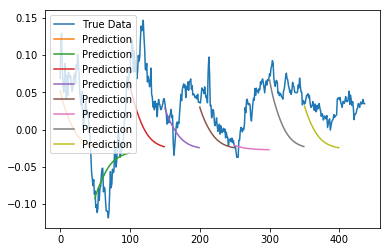

Mean squared error:  6.98992275718e-05 

R_2 score is:  0.965766681239 



In [15]:
""" Training and predicting the data. Defined functions to plot predictions results"""

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

#Main Run Thread
if __name__=='__main__':
    global_start_time = time.time()
    
     # Read data
    dates = pd.date_range('2000-01-03', '2017-07-28')
    symbols = ['SPY']
    df = get_data(symbols, dates)
    
    epochs  = 500
    seq_len = 50
    
     # Load Data
    print('> Loading data... ')
   

    X_train, y_train, X_test, y_test = load_data(df, seq_len,True)

    print('> Data Loaded. Compiling...')

    model = build_model([1, 50, 100, 1])
#Train the model

    model.fit(
        X_train,
        y_train,
        batch_size=512,
        nb_epoch=epochs,
        validation_split=0.1,
        verbose=1)
    # Predicting the model
    predictions = predict_sequences_multiple(model, X_test, seq_len, 50)

    print('Training duration (s) : ', time.time() - global_start_time)
    plot_results_multiple(predictions, y_test, 50)
    
     # The mean square error
    print "Mean squared error: ", mean_squared_error(y_test, model.predict(X_test)), "\n"
    
     # The R_2 score
    print "R_2 score is: ", r2_score(y_test, model.predict(X_test)), "\n"
   

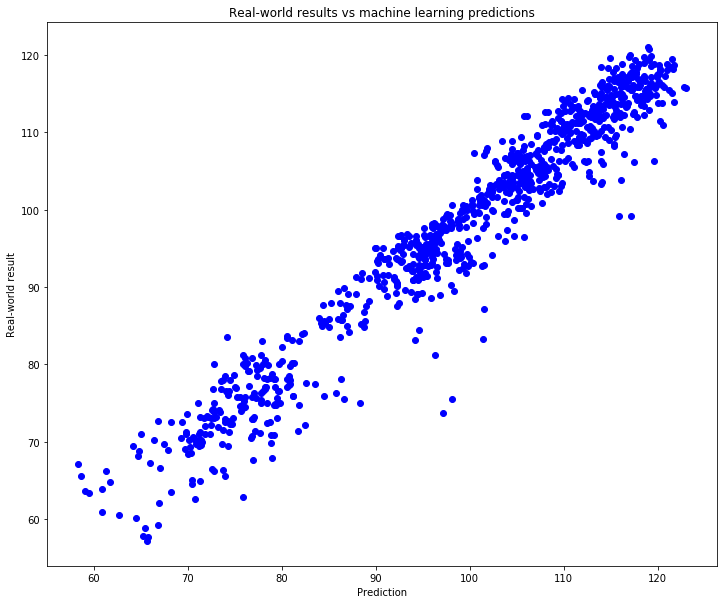

Mean squared error:  14.6820359285 

R_2 score is:  0.935150907258 



In [17]:
#Benchmark model

def linear_regression():
    
    df = pd.read_csv(symbol_to_path('SPY'), index_col='Date', 
                parse_dates=True, 
                usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], 
                na_values=['nan'])
    
    # sort data chronologically
    df = df.sort_index(ascending=True, axis=0)
    
    
    # add new column to view Adj Close  7 days later
    df['Adj_Close_7_Days_Later'] = df['Adj Close']
    df['Adj_Close_7_Days_Later'] = df['Adj_Close_7_Days_Later'].shift(-7)
    
    
   
    # Split the data into training/testing sets
    
    X_train = df.iloc[0:2000,:-1]
    y_train = df.iloc[0:2000, -1]
    X_test = df.iloc[2000:3000,:-1]
    y_test = df.iloc[2000:3000, -1]
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    
    # predict
    regr.predict(X_test)
    
    # Plot outputs
    print "\n"
    plt.figure(figsize=(12,10))
    plt.title("Real-world results vs machine learning predictions")
    plt.xlabel("Prediction")
    plt.ylabel("Real-world result")
    plt.scatter(regr.predict(X_test), y_test, color='blue')
    
    plt.show()
    
    
   
    # The mean square error
    print "Mean squared error: ", mean_squared_error(y_test, regr.predict(X_test)), "\n"
    
     # The R_2 score
    print "R_2 score is: ", r2_score(y_test, regr.predict(X_test)), "\n"
   
   

if __name__ == "__main__":
    linear_regression()